In [1]:
import sqlite3
import pandas as pd

# 1) LOAD THE CSV AND PARSE DATES
df = pd.read_csv("Infosys.csv")
df["Date"] = pd.to_datetime(
    df["Date"], format="%d-%B-%Y"
)  # e.g. "31-July-2018" → 2018-07-31
df = df.sort_values("Date", ascending=True).reset_index(
    drop=True
)  # Ensure ascending order


In [2]:
# 2) PUSH INTO SQLITE (so we can run SQL queries)
#    Convert Date into ISO format (YYYY-MM-DD) so that SQL can match on exact strings.
df_sql = df.copy()
df_sql["Date"] = df_sql["Date"].dt.strftime("%Y-%m-%d")

conn = sqlite3.connect(":memory:")
df_sql.to_sql("infosys", conn, index=False, if_exists="replace")

889

In [3]:
# 3) EXTRACT CLOSE ON 01-JAN-2015 AND 31-JUL-2018 VIA SQL
query_close_2015 = "SELECT [Close Price] FROM infosys WHERE Date = '2015-01-01';"
query_close_2018 = "SELECT [Close Price] FROM infosys WHERE Date = '2018-07-31';"

close_2015 = conn.execute(query_close_2015).fetchone()[0]
close_2018 = conn.execute(query_close_2018).fetchone()[0]

In [4]:
# 4) USE PANDAS TO COMPUTE “BUY”/“SELL” SIGNALS (BASED ON PRICE MOVEMENT)
df["Prev_Close"] = df["Close Price"].shift(1)


def classify_signal(row):
    if pd.isna(row["Prev_Close"]):
        return "Hold"
    if row["Close Price"] > row["Prev_Close"]:
        return "Buy"
    elif row["Close Price"] < row["Prev_Close"]:
        return "Sell"
    else:
        return "Hold"


df["Signal"] = df.apply(classify_signal, axis=1)

In [5]:
# 5) COUNT NUMBER OF “BUY” AND “SELL” SIGNALS
buy_count = df[df["Signal"] == "Buy"].shape[0]
sell_count = df[df["Signal"] == "Sell"].shape[0]

In [6]:
# 6) DETERMINE TREND ON 05-JUN-2018
target_date = pd.to_datetime("05-06-2018", format="%d-%m-%Y")
row_05062018 = df[df["Date"] == target_date]
if not row_05062018.empty:
    comparison = float(row_05062018["Close Price"].iloc[0]) - float(
        row_05062018["Prev_Close"].iloc[0]
    )
    trend_05062018 = "up" if comparison > 0 else "down"
else:
    trend_05062018 = "Date not found in dataset"

In [7]:
# 7) PERCENTAGE CHANGE FROM 01-JAN-2015 TO 31-JUL-2018
percent_change = ((close_2018 - close_2015) / close_2015) * 100

In [8]:
# 8) PACKAGE ALL RESULTS INTO A TABLE AND DISPLAY
results = {
    "Metric": [
        "Buy Signals Count",
        "Sell Signals Count",
        "Trend on 05-06-2018",
        "Close Price on 01-01-2015",
        "Close Price on 31-07-2018",
        "Percentage Change (2015→2018)",
    ],
    "Value": [
        buy_count,
        sell_count,
        trend_05062018,
        close_2015,
        close_2018,
        f"{percent_change:.2f}%",
    ],
}

results_df = pd.DataFrame(results)

In [9]:
# Display the results
print(results_df.to_string(index=False))
# Close the SQLite connection
conn.close()

                       Metric   Value
            Buy Signals Count     440
           Sell Signals Count     447
          Trend on 05-06-2018    down
    Close Price on 01-01-2015  1975.8
    Close Price on 31-07-2018  1365.0
Percentage Change (2015→2018) -30.91%


In [10]:
# Stock Market Analysis for Infosys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('Infosys.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d-%B-%Y')
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Fill missing values
df.fillna(method='ffill', inplace=True)

# Basic Overview
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       889 non-null    datetime64[ns]
 1   Open Price                 889 non-null    float64       
 2   High Price                 889 non-null    float64       
 3   Low Price                  889 non-null    float64       
 4   Close Price                889 non-null    float64       
 5   WAP                        889 non-null    float64       
 6   No.of Shares               889 non-null    int64         
 7   No. of Trades              889 non-null    int64         
 8   Total Turnover (Rs.)       889 non-null    float64       
 9   Deliverable Quantity       889 non-null    float64       
 10  % Deli. Qty to Traded Qty  889 non-null    float64       
 11  Spread High-Low            889 non-null    float64       
 12  Spread C

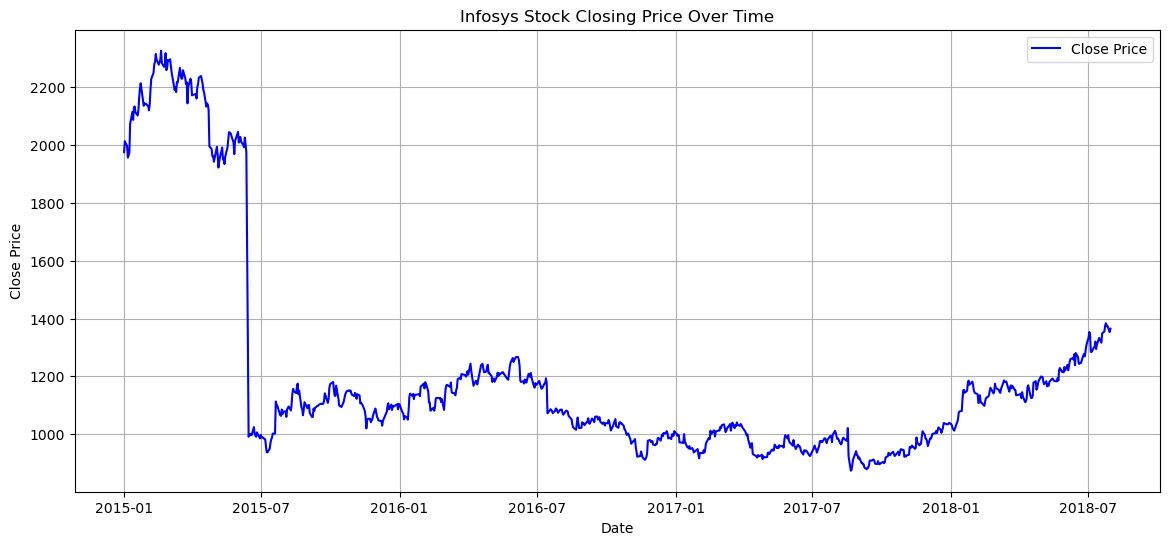

In [11]:
# 1. Time Series of Closing Price
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Close Price'], label='Close Price', color='blue')
plt.title('Infosys Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

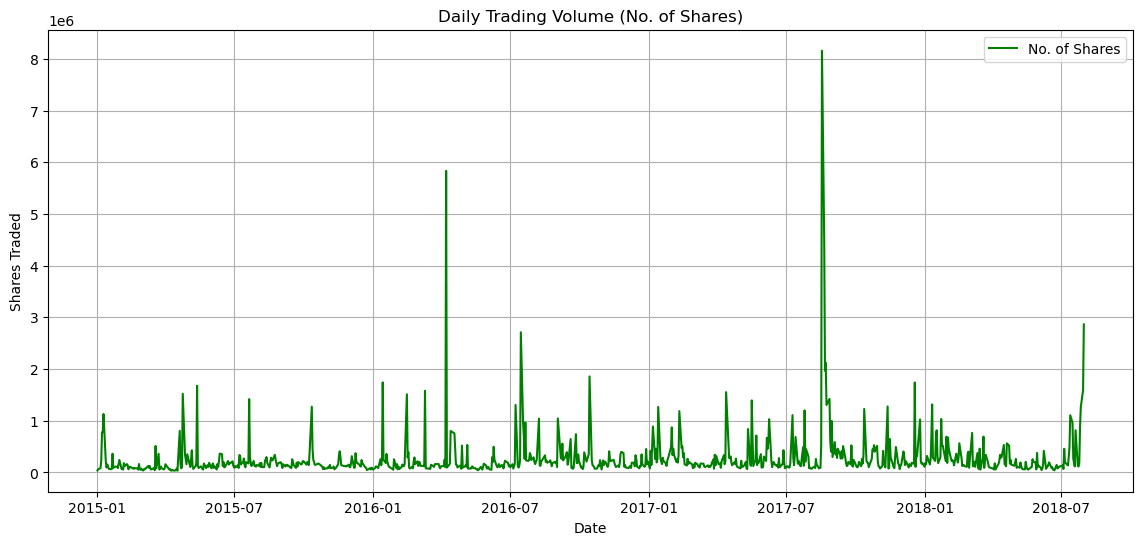

In [12]:
# 2. Volume Analysis
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['No.of Shares'], label='No. of Shares', color='green')
plt.title('Daily Trading Volume (No. of Shares)')
plt.xlabel('Date')
plt.ylabel('Shares Traded')
plt.legend()
plt.grid(True)
plt.show()

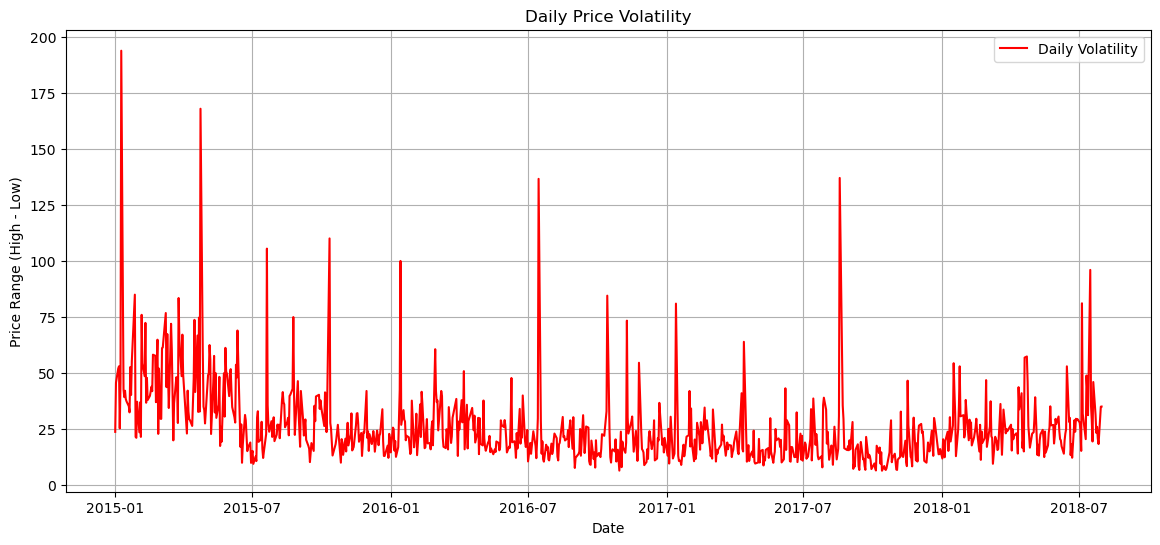

In [13]:
# 3. Volatility Analysis
volatility = df['High Price'] - df['Low Price']
plt.figure(figsize=(14,6))
plt.plot(df['Date'], volatility, label='Daily Volatility', color='red')
plt.title('Daily Price Volatility')
plt.xlabel('Date')
plt.ylabel('Price Range (High - Low)')
plt.legend()
plt.grid(True)
plt.show()

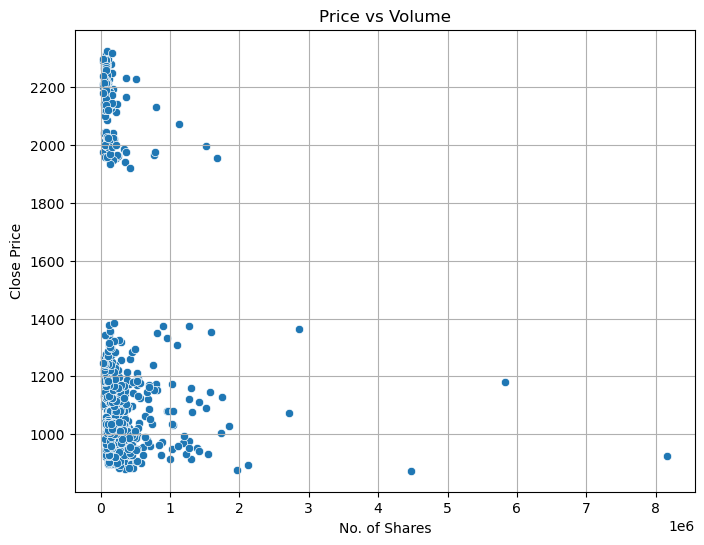

In [14]:
# 4. Price-Volume Correlation
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['No.of Shares'], y=df['Close Price'])
plt.title('Price vs Volume')
plt.xlabel('No. of Shares')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

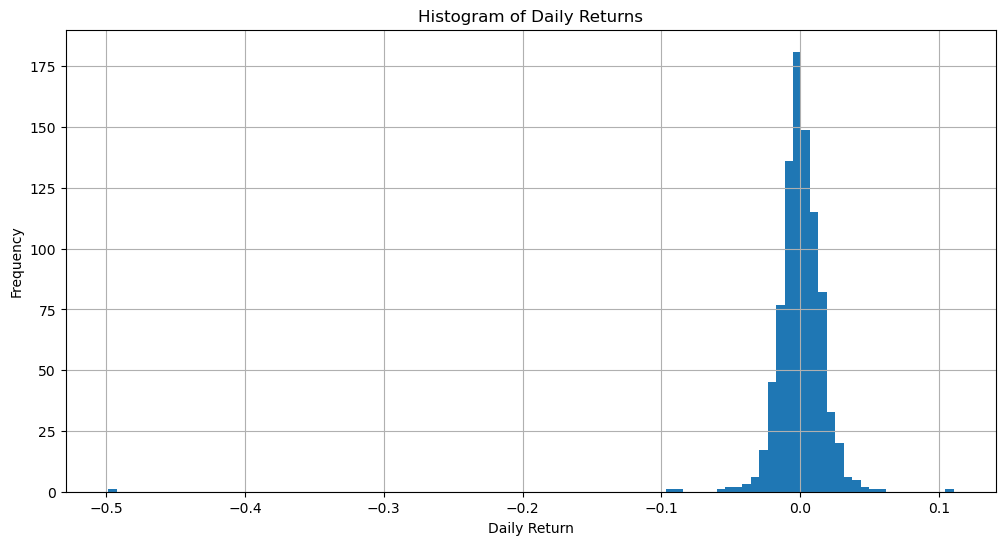

In [15]:
# 5. Daily Returns Analysis
df['Daily Return'] = df['Close Price'].pct_change()
plt.figure(figsize=(12,6))
df['Daily Return'].hist(bins=100)
plt.title('Histogram of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [16]:
# 6. Unusual Activity Detection
threshold = 3 * df['No.of Shares'].std()
unusual_days = df[df['No.of Shares'] > df['No.of Shares'].mean() + threshold]
print("Unusual Trading Volume Days:")
print(unusual_days[['Date', 'No.of Shares', 'Close Price']])

Unusual Trading Volume Days:
          Date  No.of Shares  Close Price
88  2015-05-13       1676667      1955.95
257 2016-01-14       1741690      1128.70
313 2016-04-07       5832025      1181.65
380 2016-07-15       2710883      1072.25
440 2016-10-14       1856578      1027.40
651 2017-08-18       8157426       923.10
652 2017-08-21       4476699       873.50
653 2017-08-22       1967963       877.15
654 2017-08-23       2121468       894.50
735 2017-12-19       1739637      1004.80
888 2018-07-31       2863072      1365.00


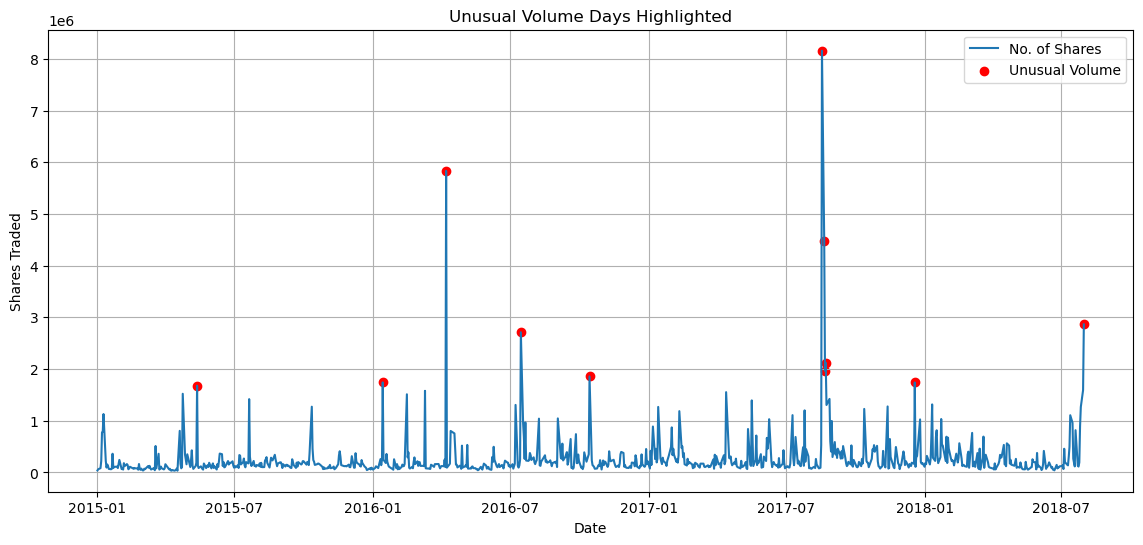

In [17]:
# Highlighting on plot
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['No.of Shares'], label='No. of Shares')
plt.scatter(unusual_days['Date'], unusual_days['No.of Shares'], color='red', label='Unusual Volume')
plt.title('Unusual Volume Days Highlighted')
plt.xlabel('Date')
plt.ylabel('Shares Traded')
plt.legend()
plt.grid(True)
plt.show()

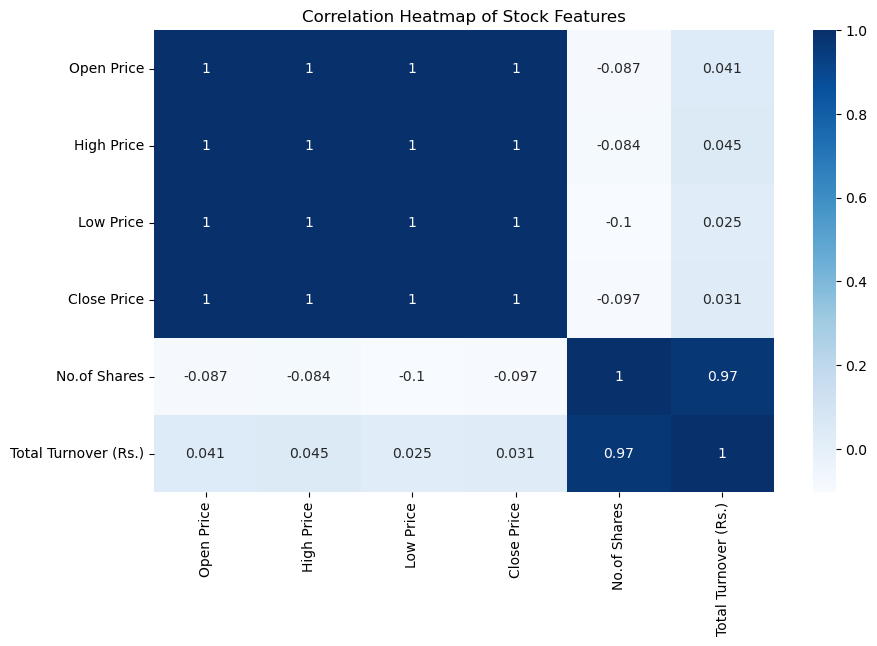

In [18]:
# 7. Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df[['Open Price', 'High Price', 'Low Price', 'Close Price', 'No.of Shares', 'Total Turnover (Rs.)']].corr(), annot=True, cmap='Blues')
plt.title('Correlation Heatmap of Stock Features')
plt.show()